# ДЗ:
1. Сделать разведочный анализ данных, найти пропуски и выбросы. Примеры есть в ноутбуке EDA_AUTO из 4 задания.
2. Заполнить пропуски. Заполнить медианой или обучить линейную регрессию и заполнить ею пропуски. Если заполните линейной регрессией пропуски, то с помощью таблицы корреляций найдите второй признак, который имеет сильную взаимосвязь с первым признаком. Создаете отдельный датафрейм из этих признаков, исключаете пропуски (не удаляете), обучаете линейну регрессию. Затем прогнозируете на исключенных данных с пропусками и заполняете эти пропуски предсказанным значением.
3. Обучить множественную линейную регрессию. Она будет являться base line, т.е. базовая модель. С ней вы будете сравнивать другие модели.
4. Используя кроссвалидацию, подбор гиперпараметров обучить модели Lasso regression, Ridge Regression, ElasticNet (модель где Ridge + Lasso вместе используется), DecisionTreeRegressor, SVR, RandomForestRegressor

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV # Линейна регрессия, Ридж и Лассо
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV # Ridge и Lasso Регрессия
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column',None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-41f3d8d78b0d>:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [6]:
data = pd.read_csv("data.csv")
data

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
0,50.074285,50.656771,500.475537,1207.542773,912.161426,119.562970,51.248955
1,50.074926,50.656771,500.379883,1209.190723,914.203027,119.683643,51.255357
2,50.074836,50.666920,499.359570,1210.159082,914.924512,119.665576,51.263570
3,50.074957,50.666920,500.535840,1210.641602,915.881055,119.674750,51.267725
4,50.075145,50.666920,500.198145,1211.398438,916.435645,119.692188,51.264826
...,...,...,...,...,...,...,...
29707,50.070496,52.706500,459.827393,1238.176660,914.571973,128.579962,51.102349
29708,50.070217,52.716716,459.400806,1237.532422,913.476074,128.521655,51.102543
29709,50.070292,52.696284,459.942578,1237.783984,913.913086,128.503632,51.102639
29710,50.070389,52.675853,460.185791,1237.441895,913.895508,128.481744,51.103799


In [7]:
data.head()

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
0,50.074285,50.656771,500.475537,1207.542773,912.161426,119.562970,51.248955
1,50.074926,50.656771,500.379883,1209.190723,914.203027,119.683643,51.255357
2,50.074836,50.666920,499.359570,1210.159082,914.924512,119.665576,51.263570
3,50.074957,50.666920,500.535840,1210.641602,915.881055,119.674750,51.267725
4,50.075145,50.666920,500.198145,1211.398438,916.435645,119.692188,51.264826


In [8]:
data.isnull().sum()

KS4_GPA5_Qtg.PV         0
KS4_GPA5_TC_T1.PV       0
KS4_GPA5_Nst.PV         0
KS4_GPA5_Nvd.PV         0
KS4_GPA5_Nnd.PV      2001
KS4_GPA5_T4.PV          0
KS4_GPA5_Pk.PV          0
dtype: int64

In [11]:
data.describe()

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
count,29712.000000,29712.000000,29712.000000,29712.000000,27711.000000,29712.000000,29712.000000
mean,50.075761,51.582940,496.375057,1228.936047,925.288586,123.147985,51.579620
std,0.004490,0.718957,16.656003,9.293723,12.649640,2.293297,58.430508
min,50.067757,50.118885,458.647290,1207.311621,910.000195,118.375299,51.074956
25%,50.072440,50.940938,484.903076,1222.372168,915.022510,121.428400,51.183080
50%,50.074476,51.725804,490.411133,1228.801709,920.266797,123.233508,51.244438
75%,50.079485,52.134428,509.792322,1236.431030,936.632568,125.019626,51.271976
max,50.089918,53.053829,526.688867,1264.442773,977.826953,128.815308,10123.000000


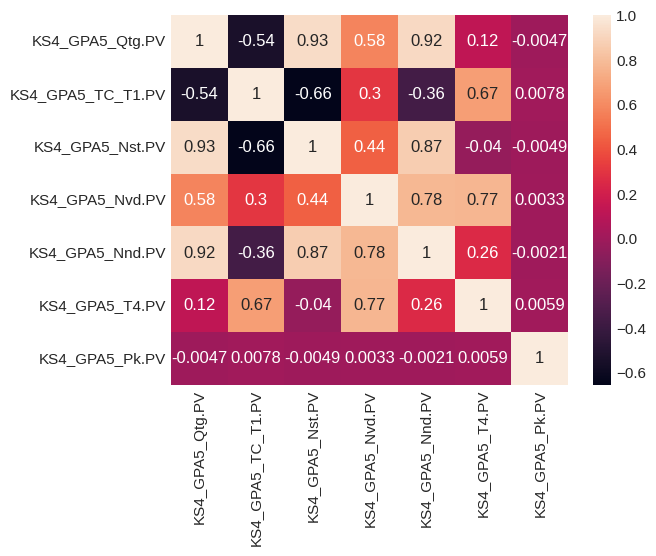

In [12]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [13]:
data['KS4_GPA5_Nnd.PV'].fillna(df['KS4_GPA5_Nnd.PV'].mean(), inplace=True)
data['KS4_GPA5_Pk.PV'].sort_values(ascending=False)

20100    10123.000000
7611        51.402325
7613        51.401648
7623        51.401648
7633        51.401358
             ...     
29664       51.096454
29671       51.096261
29672       51.095778
29674       51.095585
28419       51.074956
Name: KS4_GPA5_Pk.PV, Length: 29712, dtype: float64

In [16]:
data['KS4_GPA5_Pk.PV'][20100] = data['KS4_GPA5_Pk.PV'].mean()

In [19]:
corr = data.corr()
corr

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
KS4_GPA5_Qtg.PV,1.000000,-0.543281,0.933254,0.579065,0.914682,0.123209,0.905568
KS4_GPA5_TC_T1.PV,-0.543281,1.000000,-0.655131,0.303891,-0.356803,0.674684,-0.777480
KS4_GPA5_Nst.PV,0.933254,-0.655131,1.000000,0.444917,0.859465,-0.040373,0.943228
KS4_GPA5_Nvd.PV,0.579065,0.303891,0.444917,1.000000,0.759875,0.769571,0.310423
KS4_GPA5_Nnd.PV,0.914682,-0.356803,0.859465,0.759875,1.000000,0.248225,0.835590
KS4_GPA5_T4.PV,0.123209,0.674684,-0.040373,0.769571,0.248225,1.000000,-0.239046
KS4_GPA5_Pk.PV,0.905568,-0.777480,0.943228,0.310423,0.835590,-0.239046,1.000000


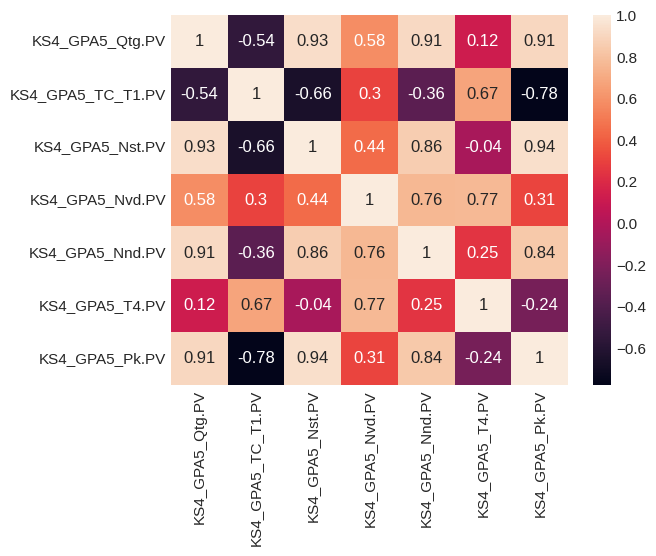

In [20]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [21]:
inputs = ['KS4_GPA5_Qtg.PV', 'KS4_GPA5_TC_T1.PV', 'KS4_GPA5_Nst.PV'] # предикторы
outputs = ['KS4_GPA5_Nvd.PV', 'KS4_GPA5_Nnd.PV', 'KS4_GPA5_T4.PV', 'KS4_GPA5_Pk.PV'] # отклики, целевые признаки

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

X = data[inputs]
y = data[outputs]

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели множественной линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка (MSE): {mse}")
print(f"Коэффициент детерминации (R^2): {r2}")

Среднеквадратичная ошибка (MSE): 7.3991342486284575
Коэффициент детерминации (R^2): 0.8735212584551276


In [25]:
lasso = Lasso()
lasso_params = {'alpha': [0.0001, 0.001,0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X, y)

print(f'test: {lasso_grid.score(X_test, y_test)}')
print(f'train: {lasso_grid.score(X_train, y_train)}')

test: 0.8697474168392569
train: 0.8751098021110401


In [27]:
ridge = Ridge()
ridge_params = {'alpha': [0.0001, 0.001,0.01, 0.1, 1, 10]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(X, y)

print(f'test: {ridge_grid.score(X_test, y_test)}')
print(f'train: {ridge_grid.score(X_train, y_train)}')

test: 0.8734202911553051
train: 0.8785843023386604


In [28]:
elasticnet = ElasticNet()
elasticnet_params = {'alpha': [0.0001, 0.001,0.01, 0.1, 1, 10], 'l1_ratio': [0.01, 0.1, 0.5, 1, 5, 10, 15, 20]}
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5)
elasticnet_grid.fit(X, y)

print(f'test: {elasticnet_grid.score(X_test, y_test)}')
print(f'train: {elasticnet_grid.score(X_train, y_train)}')

test: 0.8697474168392569
train: 0.8751098021110401


In [38]:
tree_regressor = DecisionTreeRegressor()
tree_params = {'max_depth': [None, 10, 20, 30, 40, 50]}
tree_grid = GridSearchCV(tree_regressor, tree_params, cv=5)
tree_grid.fit(X, y)

print(f'test: {tree_grid.score(X_test, y_test)}')
print(f'train: {tree_grid.score(X_train, y_train)}')

test: 0.9991723253388292
train: 0.999058720503065


In [51]:
svr_grid = {'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01]}

svr_regressor = GridSearchCV(MultiOutputRegressor(SVR()), param_grid=svr_grid, n_jobs=-1)
svr_regressor.fit(X, y)

GridSearchCV(estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid={'estimator__C': [0.001, 0.01],
                         'estimator__gamma': [0.001, 0.01]})

In [52]:
print(f'test: {svr_regressor.score(X_test, y_test)}')
print(f'train: {svr_regressor.score(X_train, y_train)}')

test: 0.44594386308286493
train: 0.4433755970291006


In [53]:
random_forest_regressor  = GridSearchCV(RandomForestRegressor(), param_grid={
    'max_features': [1, 2, 3]
})
random_forest_regressor.fit(X, y)

print(f'test: {random_forest_regressor.score(X_test, y_test)}')
print(f'train: {random_forest_regressor.score(X_train, y_train)}')

test: 0.9988651055471987
train: 0.9988603826902633
